# Importing

In [2]:
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tfd = tfp.distributions

import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')

# GMM Creation

In [3]:
class Gaussian:
    def __init__(self, mu=None, sigma=None) -> None:
        '2D Gaussian pdf'
        D = 2
        self.mu = mu if mu is not None else  10 * (np.random.random(D) - 0.5)
        self.sigma = sigma if sigma is not None else 0.05*(np.eye(2) + 0.1*np.random.random((2,2)))
        self.sigma = (self.sigma + self.sigma.T)/2   # to make it symmetric
        self.sigmainv = np.linalg.inv(self.sigma)
        self.Z = 2*np.pi*np.sqrt(np.linalg.det(self.sigma))
    def sample(self, S=1):
        'return SxD np array'
        return np.random.multivariate_normal(self.mu, self.sigma, size=S)
    def prob(self, x_s):
        'x_s is SxD; returns an np array of len S'
        retval = []
        for x_mu in (x_s-self.mu):
             retval.append(np.exp(-0.5*(x_mu).T @ (self.sigmainv) @ (x_mu))/self.Z)
        return np.array(retval)
        
class GMM:
    def __init__(self, N=5) -> None:
        'GMM with N Gaussian components'
        self.components = [Gaussian() for _ in range(N)] 
        self.weights = np.random.random(N)
        self.weights /= np.sum(self.weights)
    def sample(self, S=1):
        #print(self.weights)
        retval = []
        count_z = np.random.multinomial(S, self.weights)
        #print(count_z)
        for z, count in enumerate(count_z):
            retval.append(self.components[z].sample(S=count))
        return np.vstack(retval)
    def prob(self, x_s):
        retval = []
        p = np.zeros(len(x_s))
        for z, w in enumerate(self.weights):
            p += w * self.components[z].prob(x_s)
        return p
    
    def gs_components(self):
      return self.components

def plot_samples_2d(data, filename=None):
    'data is SxD'
    plt.figure(figsize=(5,5))
    plt.scatter(data[:, 0], data[:, 1]) 
    if filename:
        plt.savefig('./%s'%(filename) + ".png", format="png")

In [4]:
gmm= GMM()
gs = gmm.gs_components()

### Plot 0: True Samples from the GMM

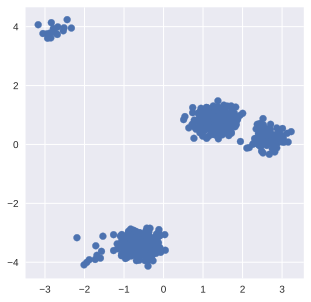

In [5]:
plot_samples_2d(gmm.sample(1000))

# Step 3: VAE

In [6]:
batch_size = 32
latent_dim = 2
epochs = 30

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
def build_encoder(dim):

    ## What is dim?
    ## dimension of input vector -- here it is 2 as we are giving in points from a GMM in 2d space
    
    ##What is the input to the encoder?
    ##Maybe one point from the GMM sampler
    
    ## What is the output of this encoder?
    ## mu and sigma of 2D Gaussian
    input_layer = layers.Input((dim,))
    X = input_layer
    for i in range(4):
        X = layers.Dense(16)(X)
        X = layers.LeakyReLU(0.1)(X)
    #output_layer = layers.Dense(output_dim)(X)

    z_mean = Dense(latent_dim, name='z_mean')(X)
    z_log_var = Dense(latent_dim, name='z_log_var')(X)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    encoder = Model(input_layer, [z_mean, z_log_var, z], name = "encoder")
    return encoder

In [9]:
encoder = build_encoder(2)

In [10]:
# encoder.summary()

In [11]:
# [t1, t2, t3] = encoder(inputs)

In [12]:
# print(t1.shape, t2.shape, t3.shape)

In [13]:
def build_decoder(output_dim):

    ## What is dim?
    ## dimension of input vector -- here it is 2 as we are giving in points from a GMM in 2d space
    
    ##What is the input to the encoder?
    ##Maybe one point from the GMM sampler
    
    ## What is the output of this encoder?
    ## mu and sigma of 2D Gaussian
    input_layer = layers.Input((latent_dim,))
    X = input_layer
    for i in range(4):
        X = layers.Dense(16)(X)
        X = layers.LeakyReLU(0.1)(X)
    output_layer = layers.Dense(output_dim)(X)
    
    decoder = Model(input_layer, output_layer, name = "decoder")
    return decoder

In [14]:
decoder = build_decoder(2)

In [15]:
# decoder.summary()

# Training with more weightage to KL divergence loss than MSE loss

In [21]:
NUM_BATCHES = 2000
BATCH_SIZE = 512

In [16]:
def loss_total_more_kl(z_log_var, z_mean, inputs, outputs):

  ## what will be the dimension of this kl_loss
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

  mse = K.sum(K.square(inputs - outputs), axis = -1)

  vae_loss = K.mean(mse + 10*kl_loss)
  return vae_loss

In [17]:
def VAE(dim, decoder, encoder):
  input_layer = layers.Input((dim,))
  [z_mean, z_log_var, z] = encoder(input_layer)
  output_layer = decoder(z)
  
  vae = Model(input_layer, output_layer)

  
  vae.add_loss(loss_total_more_kl(z_log_var, z_mean, input_layer, output_layer))
  # outputs = decoder(encoder(inputs)[2])
  # vae = Model(inputs, outputs)
  vae.compile(optimizer = 'adam')
  return vae

In [18]:
vae = VAE(2, decoder, encoder)

In [19]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          932         ['input_3[0][0]']                
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 2)            898         ['encoder[0][2]']                
                                                                                              

In [22]:
vae_losses = []
vae_accs = []

for step in range(NUM_BATCHES):
  print(f'1b: {step}/{NUM_BATCHES}', end='\r')
  # Train discriminator
  vae.trainable = True
  inputs = gmm.sample(BATCH_SIZE // 2)
  _vae_loss = vae.train_on_batch(inputs)

  vae_losses.append(_vae_loss)
  #print(_vae_loss)
  # vae_accs.append(_vae_accuracy)

# Visualizing the Latent Space - More Stress on KL Loss

In [23]:
def vae_points(inputs):
  [z_mean, z_log_var, z] = encoder(inputs)
  outputs = decoder(z)
  return z, outputs

In [24]:
z_all, _ = vae_points(gs[0].sample(200))
labels_all = tf.cast(0*tf.ones(z_all.shape[0]), dtype = tf.int32)

In [25]:
# print(z_all.shape, labels_all.shape)

In [26]:
for i in range(1, len(gs)):
  samples = gs[i].sample(200)
  # gs_samples.append(samples)
  z, _ = vae_points(samples)
  labels = tf.cast(i*tf.ones(z.shape[0]), dtype = tf.int32)
  #print(labels)

  z_all = tf.concat([z_all, z], axis = 0)
  labels_all = tf.concat([labels_all, labels], axis = 0)
  #print(labels_all)

### Plot 1: Visualizing the latent space

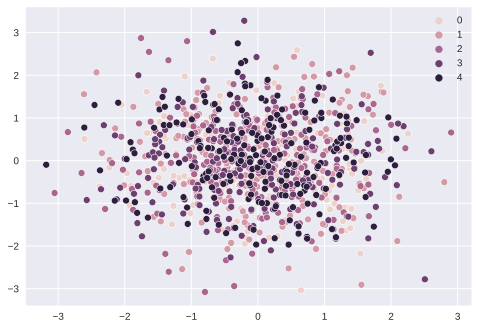

In [27]:
import seaborn as sns
sns.scatterplot(x=z_all[:, 0], y=z_all[:, 1], hue=labels_all)